In [118]:
import pandas as pd
from tqdm import tqdm

In [119]:
import random

def random_model(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["logit_0"] = pd.Series([random.uniform(-1, 1) for _ in range(len(df))])
    df["logit_1"] = pd.Series([random.uniform(-1, 1) for _ in range(len(df))])
    return df

In [120]:
df = pd.read_pickle("../results/predictions_finetuned_2e-5_bs32_e3_best.pkl")
# df = random_model(df)
print(len(df))
df.head()


1532682


,book_path,chapter_idx,paragraph_idx,labels,logit_0,logit_1
0,riehl_ovidhofe.json,0,1,1,-0.969119,-0.620473
1,riehl_ovidhofe.json,0,2,1,0.345626,-0.290198
2,riehl_ovidhofe.json,0,3,1,0.885344,0.691677
3,riehl_ovidhofe.json,0,4,1,0.935949,-0.793501
4,riehl_ovidhofe.json,0,5,1,-0.935630,-0.463830


In [121]:
def add_predictions(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["top_n_prediction"] = pd.Series([True for _ in range(len(df))])
    df["local_threshold_prediction"] = pd.Series([True for _ in range(len(df))])
    for book in tqdm(df["book_path"].unique()):
        book_df = df[df["book_path"] == book]
        predicted_chapters = book_df.sort_values("logit_0", ascending=False)[
            : len(book_df[book_df["labels"] == 0])
        ]
        for row in predicted_chapters.iterrows():
            df.loc[row[0], "top_n_prediction"] = False  # chapter break is class 0
        local_th_chapters = book_df[(book_df["logit_0"] - book_df["logit_0"].min())/(book_df["logit_0"].max() - book_df["logit_0"].min()) > 0.9]
        for row in local_th_chapters.iterrows():
            df.loc[row[0], "local_threshold_prediction"] = False  # chapter break is class 0
    df["local_prediction"] = df["logit_0"] < df["logit_1"]
    df["threshold_prediction"] = (df["logit_0"] - df["logit_0"].min())/(df["logit_0"].max() - df["logit_0"].min()) <= 0.9

    return df

pred_df = add_predictions(df)
pred_df.head()

100%|██████████| 1188/1188 [02:24<00:00,  8.25it/s]


,book_path,chapter_idx,paragraph_idx,labels,logit_0,logit_1,top_n_prediction,local_threshold_prediction,local_prediction,threshold_prediction
0,riehl_ovidhofe.json,0,1,1,-0.969119,-0.620473,True,True,True,True
1,riehl_ovidhofe.json,0,2,1,0.345626,-0.290198,True,True,False,True
2,riehl_ovidhofe.json,0,3,1,0.885344,0.691677,True,False,False,False
3,riehl_ovidhofe.json,0,4,1,0.935949,-0.793501,True,False,False,False
4,riehl_ovidhofe.json,0,5,1,-0.935630,-0.463830,True,True,True,True


In [122]:
import json
from sklearn.metrics import f1_score
from nltk.metrics import segmentation

def calc_f1_score(df: pd.DataFrame, prediction_column: str) -> float:
    # class 0 (chapter break) is relevant for us
    return f1_score(
        df["labels"].replace([1, 0], value=[False, True]),
        df[prediction_column].replace([True, False], value=[False, True]),
    )


def calc_pk_wd(df: pd.DataFrame, prediction_column: str) -> tuple:
    # class 0 (no continuation) should denote chapter break, metrics assume 1
    labels = df["labels"].replace([1, 0], value=[0, 1])
    predictions = df[prediction_column].replace([True, False], value=[0, 1])
    labels = "".join(map(str, labels))
    predictions = "".join(map(str, predictions))
    # k should be half average reference segment length
    # average paragraph count per chapter is ~54
    # median is 32
    k = int(round(len(labels) / (labels.count("1") * 2.0)))
    pk = segmentation.pk(labels, predictions, k=k)
    windowdiff = segmentation.windowdiff(labels, predictions, k=k)
    return pk, windowdiff

def calculate_metrics(df: pd.DataFrame, prediction_column: str) -> pd.DataFrame:
    results = []
    for book, group in tqdm(df.groupby(["book_path"])):
        f1 = calc_f1_score(group, prediction_column)
        pk, windowdiff = calc_pk_wd(group, prediction_column)
        with open(f"../corpus/{book}", "r") as f:
            genre = json.load(f)["genre"]
        results.append({"book": book, "f1": f1, "pk": pk, "wd": windowdiff, "genre": genre})
    return pd.DataFrame(results)

In [123]:
top_n_df = calculate_metrics(pred_df, "top_n_prediction")

print("Micro-averaged F1: ", top_n_df["f1"].mean())
print("Micro-averaged PK: ", top_n_df["pk"].mean())
print("Micro-averaged WD: ", top_n_df["wd"].mean())

100%|██████████| 1188/1188 [00:05<00:00, 237.54it/s]

Micro-averaged F1:  0.033886453957411244
Micro-averaged PK:  0.496454437375308
Micro-averaged WD:  0.542067561951841


In [124]:
genre_grouped = top_n_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

,f1,pk,wd,count
genre,,,,
"Romane, Novellen und Erzählungen",0.026880,0.499127,0.543853,852
"Krimis, Thriller, Spionage",0.010734,0.503737,0.549165,71
Historische Romane und Erzählungen,0.022831,0.501730,0.546118,65
"Märchen, Sagen, Legenden",0.142793,0.491026,0.537196,52
Kinderbücher ab 12 Jahren,0.044666,0.493782,0.538426,42
"Humor, Satire",0.106047,0.467084,0.519487,40
Spannung und Abenteuer,0.012334,0.485908,0.541831,19
Phantastische Literatur,0.021801,0.480109,0.531023,16
Romanhafte Biographien,0.045446,0.450178,0.500835,13


In [125]:
local_df = calculate_metrics(pred_df, "local_prediction")

print("Micro-averaged F1: ", local_df["f1"].mean())
print("Micro-averaged PK: ", local_df["pk"].mean())
print("Micro-averaged WD: ", local_df["wd"].mean())

100%|██████████| 1188/1188 [00:05<00:00, 231.05it/s]


Micro-averaged F1:  0.05292248288248892
Micro-averaged PK:  0.5241525491468474
Micro-averaged WD:  0.9806280143488604


In [126]:
genre_grouped = local_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

,f1,pk,wd,count
genre,,,,
"Romane, Novellen und Erzählungen",0.046731,0.526095,0.986895,852
"Krimis, Thriller, Spionage",0.028586,0.501955,0.999847,71
Historische Romane und Erzählungen,0.034336,0.512725,0.997619,65
"Märchen, Sagen, Legenden",0.175161,0.533639,0.843372,52
Kinderbücher ab 12 Jahren,0.051805,0.501802,0.986273,42
"Humor, Satire",0.116498,0.546473,0.929822,40
Spannung und Abenteuer,0.032898,0.512605,1.000000,19
Phantastische Literatur,0.053545,0.526753,0.993622,16
Romanhafte Biographien,0.034039,0.529395,0.999842,13


In [127]:
threshold_df = calculate_metrics(pred_df, "threshold_prediction")

print("Micro-averaged F1: ", threshold_df["f1"].mean())
print("Micro-averaged PK: ", threshold_df["pk"].mean())
print("Micro-averaged WD: ", threshold_df["wd"].mean())

100%|██████████| 1188/1188 [00:05<00:00, 234.28it/s]


Micro-averaged F1:  0.03597843325905878
Micro-averaged PK:  0.5155013362449492
Micro-averaged WD:  0.8594663402992588


In [128]:
genre_grouped = threshold_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

,f1,pk,wd,count
genre,,,,
"Romane, Novellen und Erzählungen",0.033168,0.518424,0.869244,852
"Krimis, Thriller, Spionage",0.021851,0.501834,0.929595,71
Historische Romane und Erzählungen,0.029126,0.514427,0.901820,65
"Märchen, Sagen, Legenden",0.081506,0.506742,0.646681,52
Kinderbücher ab 12 Jahren,0.038582,0.506590,0.889342,42
"Humor, Satire",0.070938,0.494915,0.703539,40
Spannung und Abenteuer,0.034764,0.509942,0.923186,19
Phantastische Literatur,0.035689,0.522758,0.804401,16
Romanhafte Biographien,0.038408,0.518276,0.889233,13


In [129]:
local_threshold_df = calculate_metrics(pred_df, "local_threshold_prediction")

print("Micro-averaged F1: ", local_threshold_df["f1"].mean())
print("Micro-averaged PK: ", local_threshold_df["pk"].mean())
print("Micro-averaged WD: ", local_threshold_df["wd"].mean())

100%|██████████| 1188/1188 [00:05<00:00, 235.72it/s]

Micro-averaged F1:  0.037047465235589876
Micro-averaged PK:  0.5157880312597851
Micro-averaged WD:  0.8620808038614224


In [130]:
genre_grouped = local_threshold_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

,f1,pk,wd,count
genre,,,,
"Romane, Novellen und Erzählungen",0.033758,0.518700,0.871644,852
"Krimis, Thriller, Spionage",0.021621,0.501547,0.931113,71
Historische Romane und Erzählungen,0.028970,0.514358,0.902860,65
"Märchen, Sagen, Legenden",0.094346,0.508000,0.652362,52
Kinderbücher ab 12 Jahren,0.038171,0.504383,0.889749,42
"Humor, Satire",0.075212,0.498140,0.713436,40
Spannung und Abenteuer,0.034406,0.509942,0.927191,19
Phantastische Literatur,0.034653,0.523668,0.808151,16
Romanhafte Biographien,0.038327,0.518356,0.890032,13


In [131]:
import matplotlib.pyplot as plt
import math
import numpy as np

def plot_book(dataframe: pd.DataFrame, book_id=None, fig_size=(20, 5), column="top_n_prediction"):
    f = open("output_file.txt", "w")
    book_id = book_id
    if book_id == None:
        book_id = random.choice(dataframe["book_path"])
    f.write(book_id + "\n")
    f.write(column + "\n")
    book_df = dataframe[dataframe["book_path"] == book_id]
    book_df.index = [i - min(book_df.index) for i in book_df.index]

    if column == "log_prediction":
        normalized_logit_0 = (book_df["logit_0"] - book_df["logit_0"].min())/(book_df["logit_0"].max() - book_df["logit_0"].min())
        indices = np.where(np.array(normalized_logit_0) > 0.9)[0]
        candidates = book_df.iloc[indices]
    else:
      candidates = book_df[book_df[column] == False]

    plt.figure(figsize=fig_size)
    plt.title(f"BERT-predicted chapter breaks - {book_id}")
    plt.xlabel("Paragraph")
    plt.ylabel("BERT confidence score")
    if column == "log_prediction":
        plt.scatter(book_df.index, normalized_logit_0, s=5)
        plt.scatter(candidates.index, np.array(normalized_logit_0)[indices], c="red", marker="s")
    else:
        plt.scatter(book_df.index, book_df["logit_0"], s=5)
        plt.scatter(candidates.index, candidates["logit_0"], c="red", marker="s")
    f.write("Confidences\n")
    f.write("X\n")
    f.writelines([str(v) + "\n" for v in book_df.index])
    f.write("Y\n")
    f.writelines([str(v) + "\n" for v in book_df["logit_0"]])
    f.write("Candidates\n")
    f.write("X\n")
    f.writelines([str(v) + "\n" for v in candidates.index])
    f.write("Y\n")
    f.writelines([str(v) + "\n" for v in candidates["logit_0"]])
    xcoords = book_df[book_df["labels"] == 0].index
    f.write("Breaks\n")
    f.write("X\n")
    f.writelines([str(v) + "\n" for v in xcoords])
    for x in xcoords:
        plt.axvline(x, c="green")
    f.close()
    plt.show()

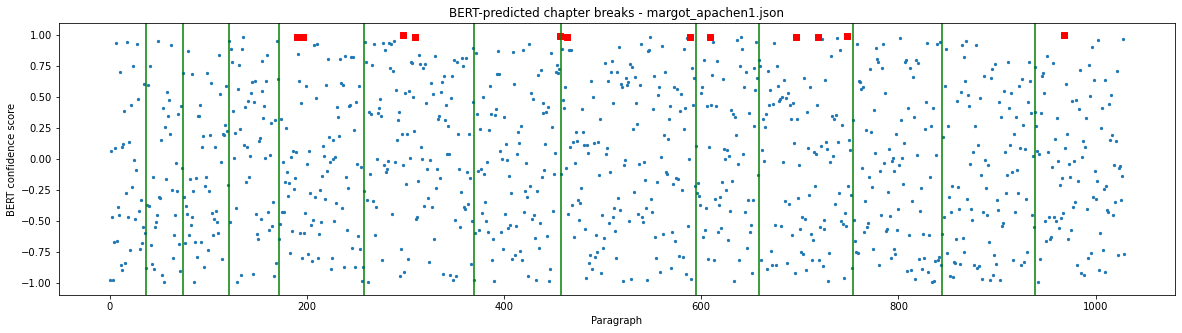

In [132]:
# potentially interesting examples:
# * margot_apachen1.json (perfect prediction)
# * may_baerenj.json (clustered predictions with peaks on chapter breaks)
# * lagerloe_christus.json (anthology w/ some multi-chapter stories inside)
plot_book(pred_df, "margot_apachen1.json", column="top_n_prediction")

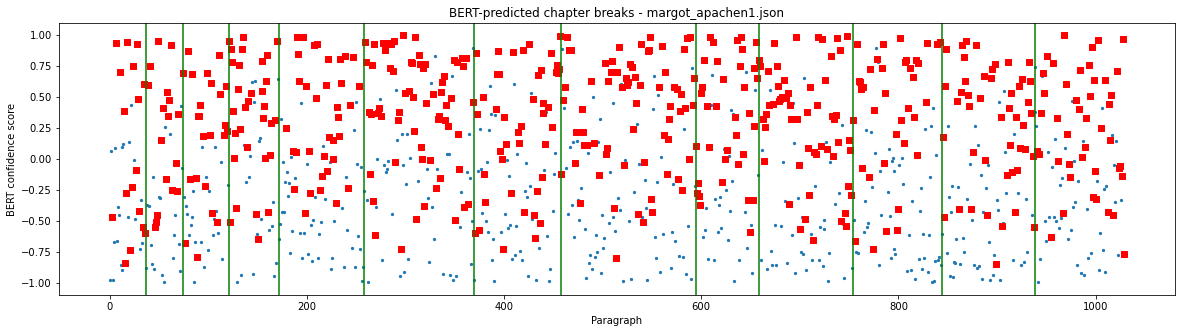

In [133]:
plot_book(pred_df, "margot_apachen1.json", column="local_prediction")

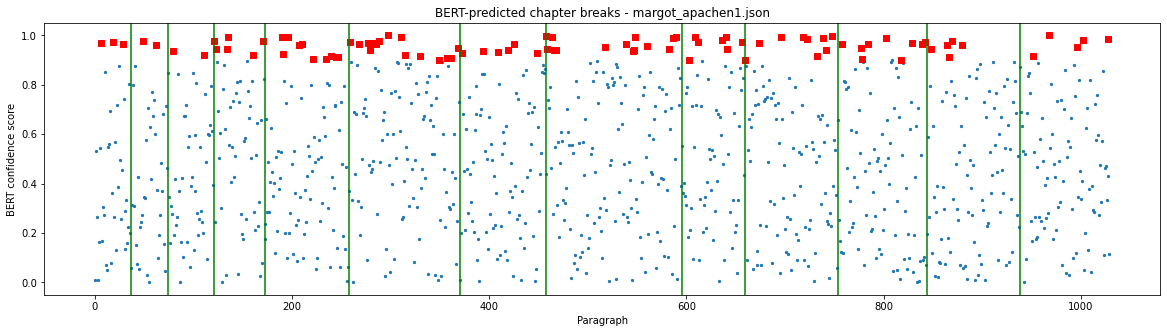

In [134]:
plot_book(pred_df, "margot_apachen1.json", column="log_prediction")

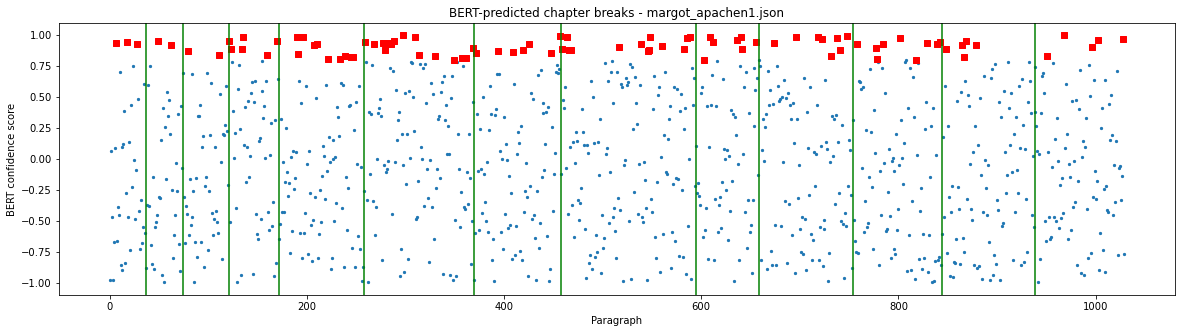

In [135]:
plot_book(pred_df, "margot_apachen1.json", column="threshold_prediction")

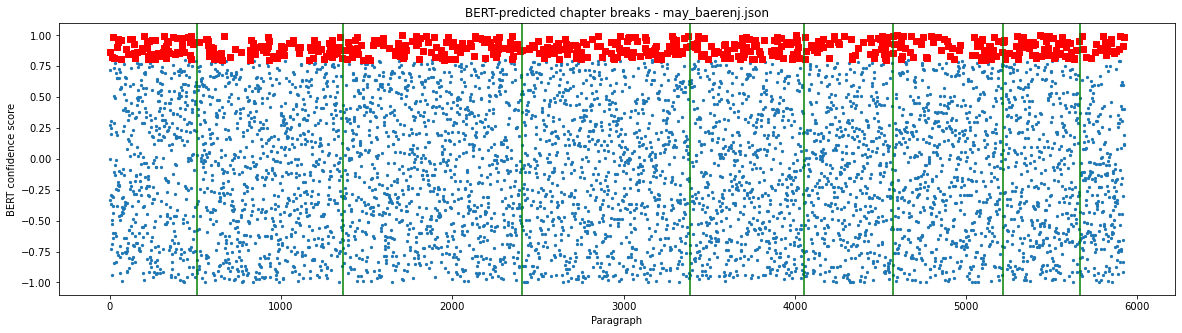

In [136]:
plot_book(pred_df, "may_baerenj.json", column="local_threshold_prediction")